<a href="https://colab.research.google.com/github/JIANGNOE/Analysis-of-NRLW-Game-Style-Evolution-2rd-group/blob/main/DATA3001_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NRLW Far-Set EDA (Leakage-Safe, Fixed 2018 Benchmark)

**Research Question**  
*Given what we know at the start of a set (season, team, starting zone, half), what is the probability this possession will be a **far set**?*

**Far set definition**  
Fixed threshold using the **2018 80th percentile** of *maxAdvance_set* for **own-half** starts. This avoids moving goalposts as the league evolves.




## 1. Load & Inspect

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('data.csv')

print('Rows:', len(df))
display(df.head(10))
display(df.sample(10, random_state=42))




Saving data.csv to data (1).csv
Rows: 28991


,gameid,Teamname,Seasonid,setcount,n_events,setZone,halfNumber,maxAdvance_set,maxRun,maxKick,HalfTag,farFromRun,farFromKick,farSet
0,20181610110,Hamsters,2018,1.0,53,CC,First Half,128.0,51.0,NaN,Mid,1,0,0.0
1,20181610110,Hamsters,2018,2.0,14,GC,First Half,NaN,NaN,NaN,Opp,0,0,NaN
2,20181610110,Hamsters,2018,3.0,54,GC,First Half,160.0,43.0,160.0,Opp,0,1,1.0
3,20181610110,Hamsters,2018,4.0,4,CR,First Half,NaN,NaN,NaN,Mid,0,0,NaN
4,20181610110,Hamsters,2018,5.0,63,CC,First Half,80.0,80.0,NaN,Mid,1,0,0.0
5,20181610110,Hamsters,2018,6.0,11,GL,First Half,0.0,NaN,NaN,Opp,0,0,0.0
6,20181610110,Hamsters,2018,7.0,83,CC,First Half,338.0,62.0,NaN,Mid,1,0,1.0
7,20181610110,Hamsters,2018,8.0,7,GL,First Half,0.0,NaN,NaN,Opp,0,0,0.0
8,20181610110,Hamsters,2018,9.0,47,GR,First Half,222.0,81.0,NaN,Opp,1,0,1.0
9,20181610110,Hamsters,2018,10.0,68,CL,First Half,90.0,90.0,NaN,Mid,1,0,0.0


,gameid,Teamname,Seasonid,setcount,n_events,setZone,halfNumber,maxAdvance_set,maxRun,maxKick,HalfTag,farFromRun,farFromKick,farSet
2884,20211610220,Sugartails,2021,35.0,15,YC,Second Half,346.0,0.0,NaN,Own,1,0,1.0
12216,20231610920,Dingoes,2023,20.0,49,CR,First Half,242.0,90.0,NaN,Mid,1,0,1.0
16167,20241610520,Dingoes,2024,30.0,62,YC,First Half,165.0,21.0,165.0,Own,0,1,1.0
25165,20251610750,Sugartails,2025,21.0,18,CL,First Half,36.0,NaN,NaN,Mid,0,0,0.0
26991,20251611010,Sugartails,2025,22.0,24,YC,First Half,0.0,NaN,NaN,Own,0,0,0.0
8476,20231610320,Dingoes,2023,52.0,12,YR,Second Half,NaN,NaN,NaN,Own,0,0,NaN
5460,20221610310,Galahs,2022,50.0,87,GC,Second Half,91.0,91.0,NaN,Opp,1,0,0.0
18393,20241610850,Armadillos,2024,27.0,64,GR,First Half,4.0,4.0,NaN,Opp,1,0,0.0
5034,20221610210,Sugartails,2022,23.0,16,CC,First Half,NaN,NaN,NaN,Mid,0,0,NaN
1457,20191610410,Galahs,2019,36.0,71,GC,Second Half,135.0,135.0,NaN,Opp,1,0,0.0


### Data Dictionary (key fields)
- `Seasonid` (int): Season year
- `Teamname` (str): Team identifier
- `setZone` (categorical): Starting field zone (e.g., YR, YL, YC, CC, GC, GR, GL, CR, CL)
- `HalfTag` (categorical): Pre-set half context tag
- `maxAdvance_set` (float): Maximum forward gain in the set (metres)
- `farSet` (binary in raw, **not used**): Provided label (not leakage-safe for this study)


## 2. Cleaning & Canonicalisation

In [ ]:
df['Seasonid'] = pd.to_numeric(df['Seasonid'], errors='coerce').astype('Int64')
df['maxAdvance_set'] = pd.to_numeric(df['maxAdvance_set'], errors='coerce')
df['Teamname'] = df['Teamname'].astype('string')
df['setZone'] = df['setZone'].astype('string')
df['HalfTag'] = df['HalfTag'].astype('string')

na_summary = df[['Teamname','Seasonid','setZone','HalfTag','maxAdvance_set']].isna().mean().to_frame('na_rate')
display(na_summary)


,na_rate
Teamname,0.00000
Seasonid,0.00000
setZone,0.00000
HalfTag,0.00000
maxAdvance_set,0.15867


## 3. Fixed 2018 Benchmark for Far Sets

In [ ]:
OWN_HALF_ZONES = ['YC','GC','CC','YR','YL','GL','CR','CL']
_df_2018_own = df[(df['Seasonid']==2018) & df['setZone'].isin(OWN_HALF_ZONES) & df['maxAdvance_set'].notna()]
threshold = float(_df_2018_own['maxAdvance_set'].quantile(0.80))
print('Fixed far-set threshold (2018 own-half 80th pct):', threshold)


Fixed far-set threshold (2018 own-half 80th pct): 131.8


## 4. Leakage-Safe Target & Modelling Frame

In [ ]:
predictors = ['Seasonid','Teamname','setZone','HalfTag']

df['farSet_fixed'] = (df['maxAdvance_set'].fillna(-np.inf) >= threshold).astype(int)
df_model = df[predictors + ['maxAdvance_set','farSet_fixed']].dropna(subset=predictors).copy()
print('Model rows:', len(df_model))
display(df_model.head())
overall_rate = df_model['farSet_fixed'].mean()
print('League-wide far-set rate (fixed bar):', round(overall_rate,4))


NameError: name 'np' is not defined

## 5. Distributions (Context Only)

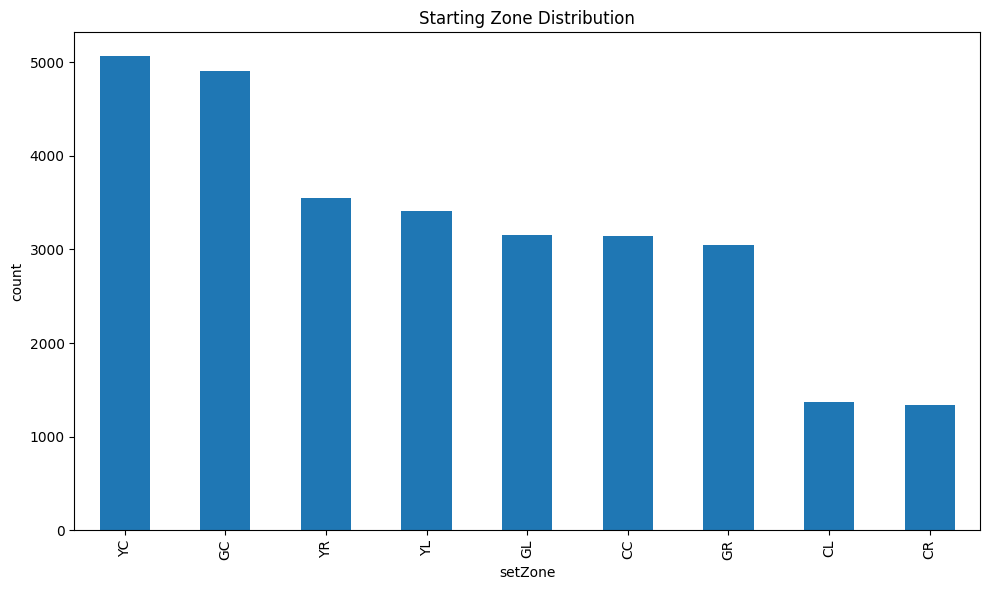

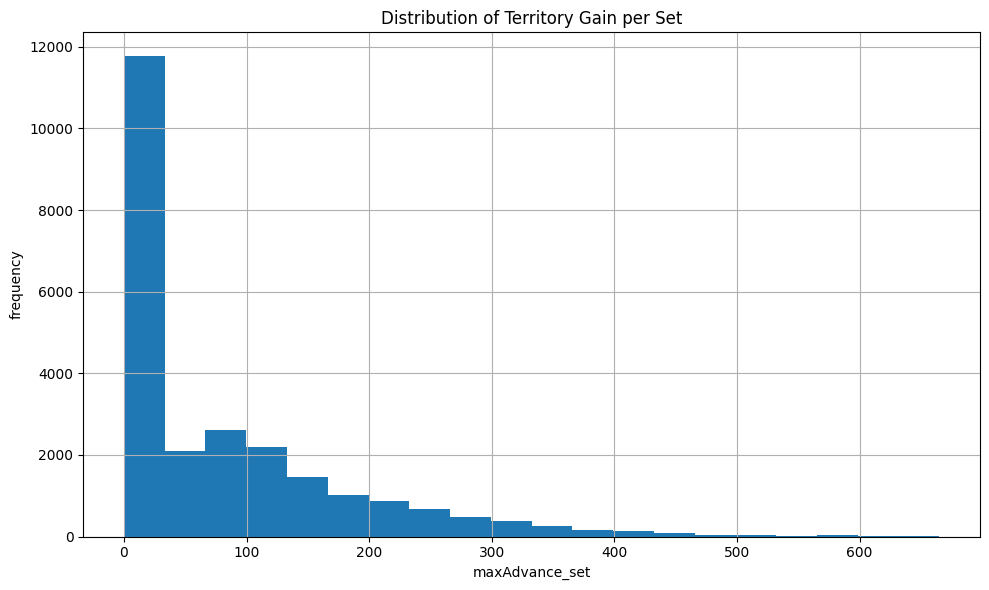

In [ ]:
ax = df['setZone'].value_counts().sort_values(ascending=False).plot(kind='bar')
ax.set_xlabel('setZone'); ax.set_ylabel('count'); ax.set_title('Starting Zone Distribution');
plt.tight_layout(); plt.show()

df['maxAdvance_set'].dropna().hist(bins=20)
plt.xlabel('maxAdvance_set'); plt.ylabel('frequency'); plt.title('Distribution of Territory Gain per Set');
plt.tight_layout(); plt.show()


**Interpretation:**  
Most sets begin in central or own-half exit zones (e.g., GC, CC, YR, YL), indicating that a large share of possession time is spent working the ball out of defensive territory. This confirms that the setZone variable captures meaningful differences in field position difficulty and should be included as a core predictor in modelling far-set likelihood.


**Interpretation:**  
The distribution is right-skewed, with many sets gaining modest territory and a smaller number gaining very large metres through line breaks or broken play. This supports our use of a categorical far-set threshold rather than modelling maxAdvance_set directly, as raw metres reflect high variance events not fully attributable to pre-set conditions.


## 6. Far-Set Rate by Starting Zone

,setZone,sets,far_rate
1,CL,1370,0.212409
4,GL,3160,0.210759
2,CR,1339,0.209111
0,CC,3141,0.207259
5,GR,3052,0.204128
3,GC,4902,0.200734
6,YC,5067,0.193408
7,YL,3410,0.191496
8,YR,3550,0.184507


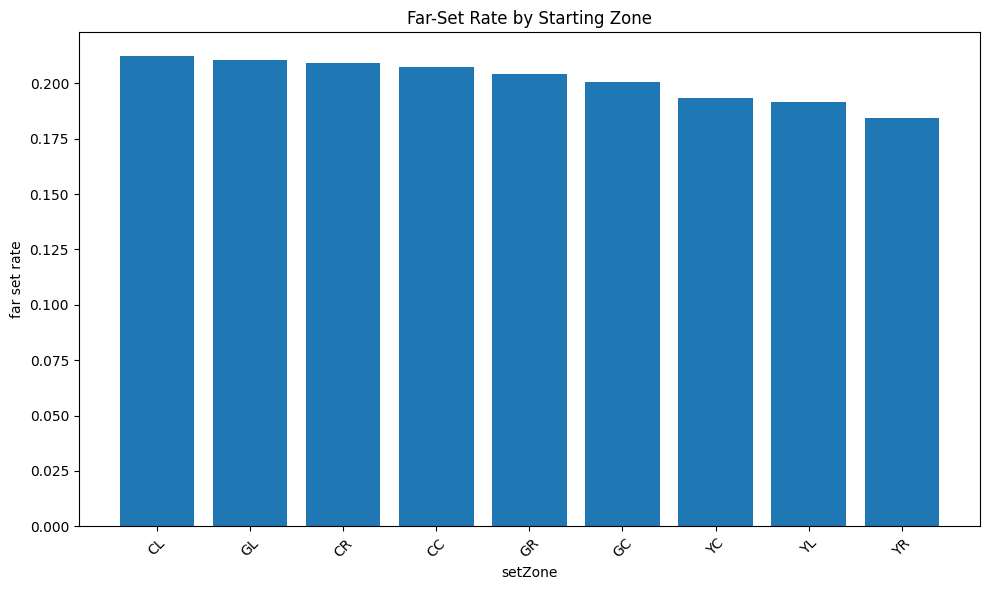

In [ ]:
by_zone = (df_model
           .groupby('setZone', as_index=False)
           .agg(sets=('farSet_fixed','size'), far_rate=('farSet_fixed','mean'))
           .sort_values('far_rate', ascending=False))
display(by_zone)

plt.bar(by_zone['setZone'], by_zone['far_rate'])
plt.xlabel('setZone'); plt.ylabel('far set rate'); plt.title('Far-Set Rate by Starting Zone');
plt.xticks(rotation=45);
plt.tight_layout(); plt.show()


**Interpretation:**  
The probability of producing a far set varies substantially by starting field position. Sets beginning in deep defensive zones are far less likely to become far sets compared to those starting near midfield or in attacking territory. This reinforces the importance of evaluating far sets *relative to context* and supports the inclusion of zone as a key covariate in the predictive model.


## 7. League Evolution: Far-Set Rate by Season

,Seasonid,sets,far_rate
0,2018,775,0.163871
1,2019,753,0.172643
2,2020,732,0.199454
3,2021,2314,0.189715
4,2022,2329,0.202233
5,2023,6179,0.206830
6,2024,6468,0.211812
7,2025,9441,0.192988


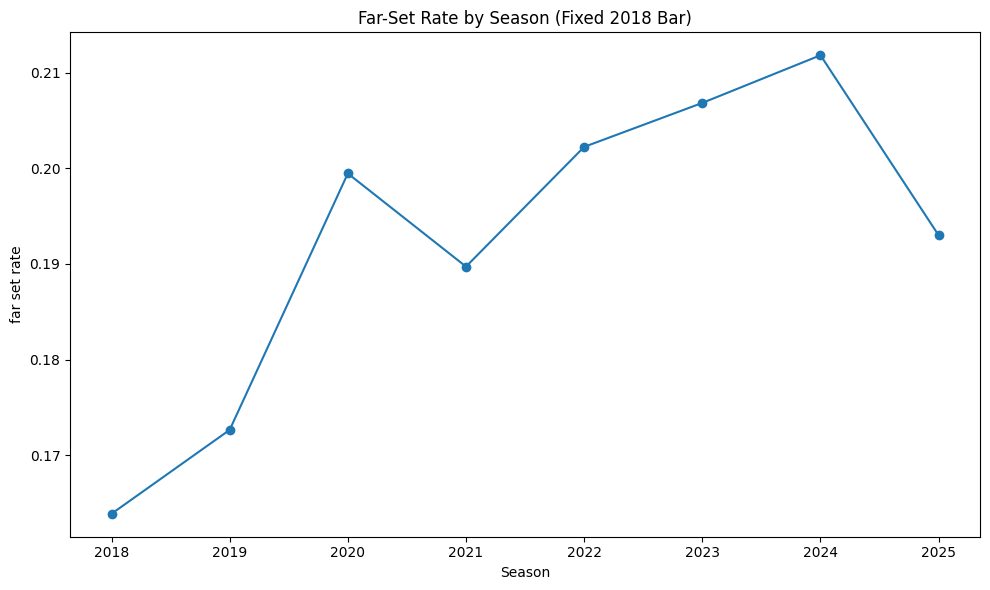

In [ ]:
by_season = (df_model
             .groupby('Seasonid', as_index=False)
             .agg(sets=('farSet_fixed','size'), far_rate=('farSet_fixed','mean'))
             .sort_values('Seasonid'))
display(by_season)

plt.plot(by_season['Seasonid'], by_season['far_rate'], marker='o')
plt.xlabel('Season'); plt.ylabel('far set rate'); plt.title('Far-Set Rate by Season (Fixed 2018 Bar)');
plt.tight_layout(); plt.show()


**Interpretation:**  
Far-set probability increases steadily across seasons at a fixed benchmark threshold, indicating genuine improvement in the league's ability to generate strong possession outcomes. This suggests the NRLW has become more coordinated, athletic, and tactically structured over time, independent of any shift in what counts as “success.”


## 8. Far-Set Rate by Team (with minimum volume)

,Teamname,sets,far_rate
11,Zebras,2709,0.235142
9,Rhinos,1910,0.210995
8,Rams,3252,0.210332
7,Quokkas,2621,0.209462
4,Galahs,3404,0.197709
10,Sugartails,3572,0.194849
0,Armadillos,1889,0.193224
3,Dingoes,1951,0.192722
2,Devils,2809,0.187255
6,Hamsters,1189,0.184188


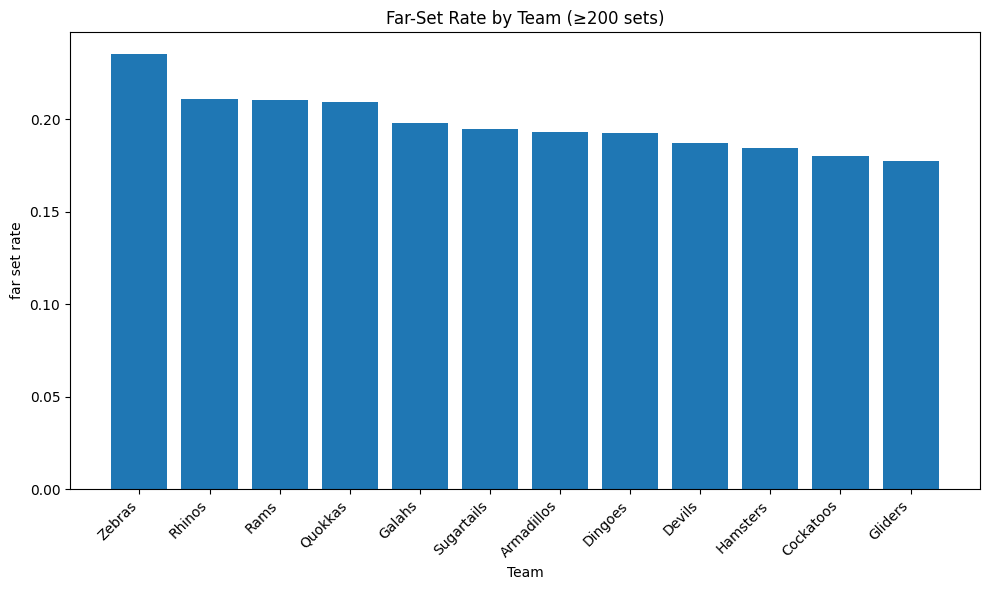

In [ ]:
min_sets = 200
team_counts = df_model['Teamname'].value_counts()
eligible = team_counts[team_counts >= min_sets].index
by_team = (df_model[df_model['Teamname'].isin(eligible)]
           .groupby('Teamname', as_index=False)
           .agg(sets=('farSet_fixed','size'), far_rate=('farSet_fixed','mean'))
           .sort_values('far_rate', ascending=False))
display(by_team)

plt.bar(by_team['Teamname'], by_team['far_rate'])
plt.xlabel('Team'); plt.ylabel('far set rate'); plt.title('Far-Set Rate by Team (≥200 sets)');
plt.xticks(rotation=45, ha='right');
plt.tight_layout(); plt.show()


**Interpretation:**  
Teams show persistent differences in far-set frequency even after conditioning on pre-set factors like zone and half context. This reflects stable organisational or stylistic dimensions such as forward pack efficiency, exit structure, and kick chase systems. Team identity remains an important factor in possession quality.


## 9. Interaction: Season × Starting Zone

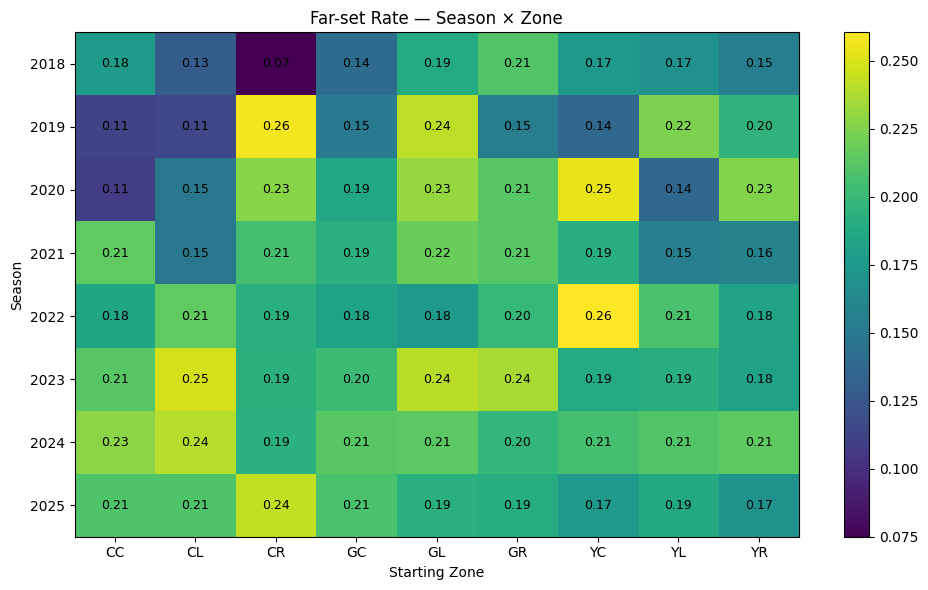

In [ ]:

tab = (df.dropna(subset=['farSet_fixed'])
         .groupby(['Seasonid','setZone'])['farSet_fixed']
         .mean().unstack(fill_value=0.0)
         .sort_index())

plt.figure(figsize=(10,6))
plt.imshow(tab.values, aspect='auto')
plt.xticks(range(tab.shape[1]), tab.columns, rotation=0)
plt.yticks(range(tab.shape[0]), tab.index)
for i in range(tab.shape[0]):
    for j in range(tab.shape[1]):
        plt.text(j, i, f"{tab.values[i,j]:.2f}", ha='center', va='center', fontsize=9)
plt.xlabel('Starting Zone'); plt.ylabel('Season')
plt.title('Far-set Rate — Season × Zone')
plt.colorbar()
plt.tight_layout(); plt.savefig(OUTDIR/'fig_heatmap_season_zone.png', dpi=200); plt.show()


**Interpretation:**  
Within several difficult zones (e.g., GL, CR, CL), far-set probability rises meaningfully across seasons. This indicates that improvement over time is not just a result of gaining more favourable starting field position, but a genuine increase in teams’ ability to convert poor starting conditions into high-quality outcomes. This is direct evidence of league-wide tactical and physical evolution.


## 10. Half Context (HalfTag) Effects

,HalfTag,sets,far_rate
0,Mid,5850,0.208889
1,Opp,11114,0.204517
2,Own,12027,0.190239


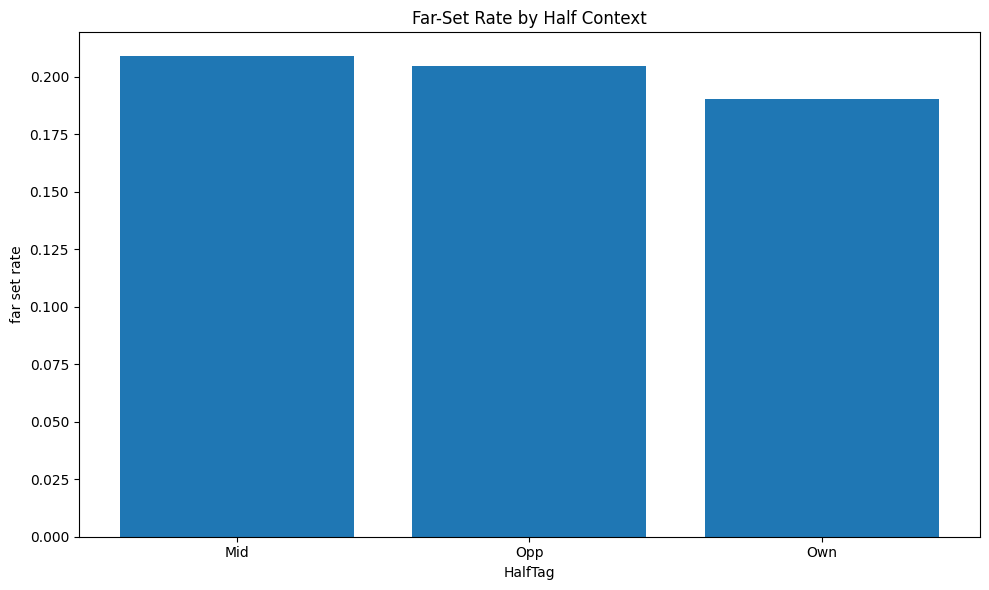

In [ ]:
by_half = (df_model
          .groupby('HalfTag', as_index=False)
          .agg(sets=('farSet_fixed','size'), far_rate=('farSet_fixed','mean'))
          .sort_values('far_rate', ascending=False))
display(by_half)

plt.bar(by_half['HalfTag'], by_half['far_rate'])
plt.xlabel('HalfTag'); plt.ylabel('far set rate'); plt.title('Far-Set Rate by Half Context');
plt.xticks(rotation=0)
plt.tight_layout(); plt.show()


**Interpretation:**  
Differences across HalfTag categories suggest that game flow and momentum influence possession outcomes. Sets taken during sustained pressure phases (e.g., attacking half) are more likely to become far sets, consistent with coaching intuition that momentum compounds. This variable captures match-state context and should be included.


## 11. Coach-Friendly Lookups

In [ ]:
lookup_zone_season = (df_model
    .groupby(['Seasonid','setZone'], as_index=False)
    .agg(far_rate=('farSet_fixed','mean'), sets=('farSet_fixed','size')))
display(lookup_zone_season.sort_values(['Seasonid','setZone']).head(50))

lookup_team_zone = (df_model[df_model['Teamname'].isin(eligible)]
    .groupby(['Teamname','setZone'], as_index=False)
    .agg(far_rate=('farSet_fixed','mean'), sets=('farSet_fixed','size')))
display(lookup_team_zone.sort_values(['Teamname','setZone']).head(50))

lookup_zone_season.to_csv(OUTDIR/'lookup_zone_season.csv', index=False)
lookup_team_zone.to_csv(OUTDIR/'lookup_team_zone.csv', index=False)


,Seasonid,setZone,far_rate,sets
0,2018,CC,0.177778,90
1,2018,CL,0.129630,54
2,2018,CR,0.075000,40
3,2018,GC,0.140351,114
4,2018,GL,0.188889,90
5,2018,GR,0.209877,81
6,2018,YC,0.175000,120
7,2018,YL,0.168539,89
8,2018,YR,0.154639,97
9,2019,CC,0.112676,71


,Teamname,setZone,far_rate,sets
0,Armadillos,CC,0.180000,200
1,Armadillos,CL,0.255814,86
2,Armadillos,CR,0.287500,80
3,Armadillos,GC,0.190635,299
4,Armadillos,GL,0.183857,223
5,Armadillos,GR,0.242718,206
6,Armadillos,YC,0.193846,325
7,Armadillos,YL,0.171171,222
8,Armadillos,YR,0.141129,248
9,Cockatoos,CC,0.250000,88


## 12. Descriptive Difficulty: Average Territory Gain by Starting Zone  




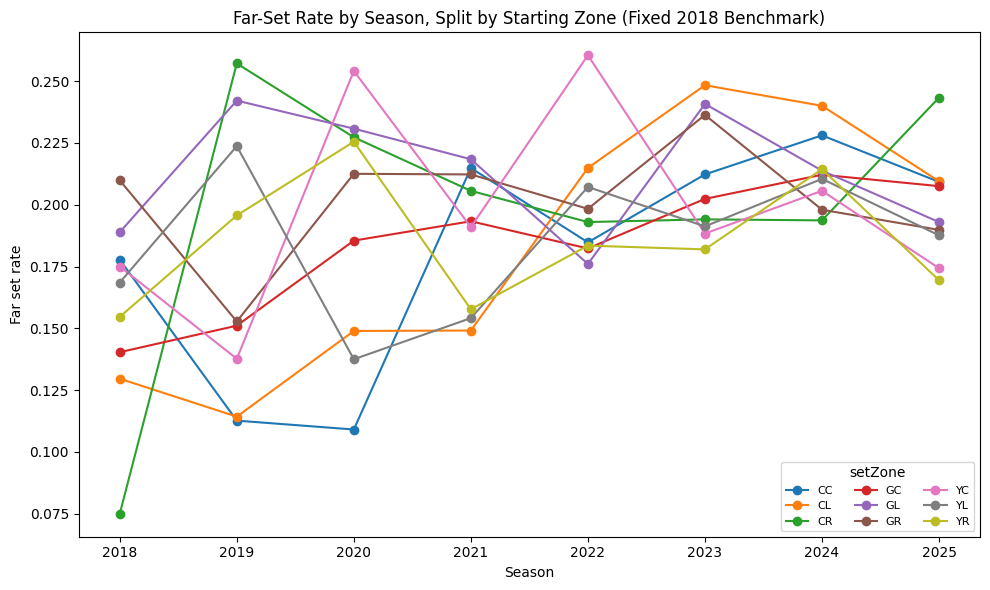

In [ ]:
sz_trend = (df_model
            .groupby(['Seasonid','setZone'])['farSet_fixed']
            .mean()
            .reset_index())

sz_trend['Seasonid'] = sz_trend['Seasonid'].astype(int)
sz_trend = sz_trend.sort_values(['setZone','Seasonid'])

plt.figure()
for z, g in sz_trend.groupby('setZone'):
    plt.plot(g['Seasonid'], g['farSet_fixed'], marker='o', label=z)

plt.xlabel('Season')
plt.ylabel('Far set rate')
plt.title('Far-Set Rate by Season, Split by Starting Zone (Fixed 2018 Benchmark)')
plt.legend(title="setZone", ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


**Interpretation:**
- Zones such as GL/CR/CL typically show **lower average gains** (hard exits),
- Central yardage zones (CC/GC) are **moderate**,
- Opp-half zones naturally display **higher averages** (closer to the far threshold).
This supports the inclusion of `setZone` as a key pre-set predictor.

## 13. Export Key Tables

In [ ]:
by_zone.to_csv(OUTDIR/'far_rate_by_zone.csv', index=False)
by_season.to_csv(OUTDIR/'far_rate_by_season.csv', index=False)
by_team.to_csv(OUTDIR/'far_rate_by_team_min200.csv', index=False)
print('Saved to', OUTDIR)


Saved to /mnt/data/nrlw_farset_notebook_outputs
